In [2]:
import os
import cv2
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import spectral


from ultralytics import YOLO
import joblib

import argparse

import cv2
import numpy as np
import onnxruntime as ort
import torch

from ultralytics.utils import ASSETS, yaml_load
from ultralytics.utils.checks import check_requirements, check_yaml




### yolo模型转成onnx模型
会在yolo 模型的同一个文件夹内生成一个onnx模型

In [129]:
yaml_load(check_yaml('D:\code\classify\yolov8\cigarette.yaml'))['names']## 目前区分类别代表的种类，直接复制下来放进初始化定义即可

In [ ]:
from ultralytics import YOLO


YOLO_model_path = r"D:\code\classify\runs\detect\train5\weights\last.pt"
# Load a model
model = YOLO(YOLO_model_path)  # load an official model

# Export the model
onnx_file = model.export(format='onnx', dynamic=True)

In [61]:

rgb_img = cv.imdecode(np.fromfile(r'I:\experiment_data\国创报告\陈皮国创演示\chenpi_data\images\train\320250926_025122.png', dtype=np.uint8),-1)
rows, cols = rgb_img.shape[:2]

### onnx模型赋值的类

In [135]:
import argparse
import cv2
import numpy as np
import onnxruntime as ort
def rgb_to_hex(rgb):
    """将RGB元组转换为十六进制颜色代码"""
    return '#{:02x}{:02x}{:02x}'.format(rgb[0], rgb[1], rgb[2])
class YOLOv12:
    def __init__(self, onnx_model, confidence_thres, iou_thres):
        """
        初始化YOLOv12类实例

        参数:
            onnx_model: ONNX模型路径
            confidence_thres: 置信度阈值，用于过滤检测结果
            iou_thres: 交并比阈值，用于非极大值抑制
        """
        self.session = ort.InferenceSession(onnx_model, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
        self.confidence_thres = confidence_thres
        self.iou_thres = iou_thres
        
        # 定义不同class_id的颜色（可以根据需要修改）
        self.class_colors = {
            0: (255, 0, 0),    # 红色 - class_id 0
            1: (0, 255, 0),    # 绿色 - class_id 1  
            2: (0, 0, 255),    # 蓝色 - class_id 2
            3: (255, 255, 0),  # 青色 - class_id 3
            4: (255, 0, 255),  # 紫色 - class_id 4
            5: (0, 255, 255),  # 黄色 - class_id 5
            # 可以继续添加更多class_id的颜色
        }
        
        # 默认颜色（当class_id不在预定义颜色中时使用）
        self.default_color = (128, 128, 128)

    def preprocess(self):
        """
        在推理前对输入图像进行预处理

        返回:
            image_data: 预处理后的图像数据，准备用于推理
        """
        # 使用OpenCV读取输入图像
        self.img = self.input_image

        # 获取输入图像的高度和宽度
        self.img_height, self.img_width = self.img.shape[:2]

        # 将图像从BGR色彩空间转换为RGB
        img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)

        # 调整图像大小以匹配输入形状
        img = cv2.resize(img, (self.input_width, self.input_height))

        # 通过除以255.0对图像数据进行归一化
        image_data = np.array(img) / 255.0

        # 转置图像，使通道维度成为第一个维度
        image_data = np.transpose(image_data, (2, 0, 1))  # 通道优先

        # 扩展图像数据的维度以匹配预期的输入形状
        image_data = np.expand_dims(image_data, axis=0).astype(np.float32)

        # 返回预处理后的图像数据
        return image_data

    def postprocess(self, input_image, output):
        """
        对模型输出进行后处理，提取边界框、分数和类别ID

        参数:
            input_image: 输入图像
            output: 模型输出

        返回:
            box: 边界框列表
            score: 置信度列表  
            class_id: 类别ID列表
        """
        # 转置并挤压输出以匹配预期形状
        outputs = np.transpose(np.squeeze(output[0]))

        # 获取输出数组的行数
        rows = outputs.shape[0]

        # 存储检测结果的边界框、分数和类别ID的列表
        boxes = []
        scores = []
        class_ids = []

        # 计算边界框坐标的缩放因子
        x_factor = self.img_width / self.input_width
        y_factor = self.img_height / self.input_height

        # 遍历输出数组中的每一行
        for i in range(rows):
            # 从当前行提取类别分数
            classes_scores = outputs[i][4:]

            # 找出类别分数中的最大值
            max_score = np.amax(classes_scores)

            # 如果最大分数高于置信度阈值
            if max_score >= self.confidence_thres:
                # 获取分数最高的类别ID
                class_id = np.argmax(classes_scores)

                # 从当前行提取边界框坐标
                x, y, w, h = outputs[i][0], outputs[i][1], outputs[i][2], outputs[i][3]

                # 将类别ID、分数和框坐标添加到相应的列表中
                class_ids.append(class_id)
                scores.append(max_score)
                boxes.append([x/ self.input_width, y/ self.input_height ,  w/ self.input_width , h/ self.input_height ])

        # 应用非极大值抑制来过滤重叠的边界框
        indices = cv2.dnn.NMSBoxes(boxes, scores, self.confidence_thres, self.iou_thres)

        box = []
        score = []
        class_id = []
        # 遍历非极大值抑制后选中的索引
        for i in indices:
            # 获取与索引对应的框、分数和类别ID
            box.append(boxes[i])
            score.append(scores[i]) 
            class_id.append(class_ids[i])

        # 返回边界框、分数和类别ID
        return box , score , class_id

    def segment_region(self, roi, class_id):
        """
        对检测框内的区域进行阈值分割并填充颜色
        
        参数:
            roi: 感兴趣区域（检测框内的图像）
            class_id: 类别ID，用于确定填充颜色
            
        返回:
            segmented_roi: 分割并填充后的区域
            mask: 分割掩码
        """
        # 将ROI转换为灰度图像
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        
        # 应用自适应阈值分割
        # 可以根据需要调整阈值方法
        _, binary_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # 对二值图像进行形态学操作，去除噪声
        kernel = np.ones((3, 3), np.uint8)
        binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
        binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
        
        # 根据class_id获取颜色
        color = self.class_colors.get(class_id, self.default_color)
        
        # 创建彩色填充图像
        color_fill = np.zeros_like(roi)
        color_fill[:] = color
        
        # 创建分割后的ROI（保留原始背景，只填充前景）
        segmented_roi = roi.copy()
        
        # 使用掩码将颜色填充到前景区域
        # 这里使用半透明填充，可以根据需要调整透明度
        alpha = 0.6  # 透明度参数
        for c in range(3):  # 对每个颜色通道
            segmented_roi[:, :, c] = np.where(
                binary_mask == 255,
                segmented_roi[:, :, c] * (1 - alpha) + color_fill[:, :, c] * alpha,
                segmented_roi[:, :, c]
            )
        
        return segmented_roi, binary_mask

    def draw_img(self, image, boxes, scores, class_ids, class_names=None):
        """
        在图像上绘制不同class_id的检测框，并对框内区域进行分割填充
        
        参数:
            image: 原始图像
            boxes: 边界框列表
            scores: 置信度列表
            class_ids: 类别ID列表
            class_names: 类别名称映射字典（可选）
            
        返回:
            image_with_boxes: 绘制了检测框和分割区域的图像
        """
        # 创建图像的副本
        image_with_boxes = image.copy()
        
        # 获取图像尺寸
        img_height, img_width = image.shape[:2]
        
        # 字体参数 - 增大字体使其更清晰
        font_scale = 1.2  # 增大字体大小（原来是0.5）
        font_thickness = 3  # 增大字体粗细（原来是1）
        box_thickness = 3   # 增大边界框线条粗细（原来是2）
        
        for i, (box, score, class_id) in enumerate(zip(boxes, scores, class_ids)):
            # 将归一化坐标转换为像素坐标
            x_center, y_center, width, height = box
            x_center = int(x_center * img_width)
            y_center = int(y_center * img_height)
            width = int(width * img_width)
            height = int(height * img_height)
            
            # 计算边界框的左上角和右下角坐标
            x_min = x_center - width // 2
            y_min = y_center - height // 2
            x_max = x_center + width // 2
            y_max = y_center + height // 2
            
            # 确保坐标在图像范围内
            x_min = max(0, x_min)
            y_min = max(0, y_min)
            x_max = min(img_width, x_max)
            y_max = min(img_height, y_max)
            
            # 提取检测框内的ROI区域
            roi = image[y_min:y_max, x_min:x_max]
            
            # 如果ROI区域有效，进行分割和填充
            if roi.size > 0:
                # 对ROI区域进行分割和颜色填充
                segmented_roi, _ = self.segment_region(roi, class_id)
                
                # 将分割后的ROI放回原图像
                image_with_boxes[y_min:y_max, x_min:x_max] = segmented_roi
            
            # 根据class_id选择颜色
            color = self.class_colors.get(class_id, self.default_color)
            
            # 绘制矩形框 - 使用更粗的线条
            cv2.rectangle(image_with_boxes, (x_min, y_min), (x_max, y_max), color, box_thickness)
            
            # 准备标签文本
            if class_names and class_id in class_names:
                label = f"{class_names[class_id]}: {score:.2f}"
            else:
                label = f"Class {class_id}: {score:.2f}"
            
            # 计算文本大小 - 使用新的字体参数
            label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)[0]
            
            # 计算标签背景位置 - 调整以适应更大的字体
            label_bg_y1 = y_min - label_size[1] - 10
            label_bg_y2 = y_min
            label_bg_x2 = x_min + label_size[0] + 5  # 增加一些边距
            
            # 确保标签背景不会超出图像顶部边界
            if label_bg_y1 < 0:
                label_bg_y1 = 0
                label_bg_y2 = label_size[1] + 10
            
            # 绘制标签背景 - 使用更深的颜色以提高可读性
            bg_color = (color[0]//2, color[1]//2, color[2]//2)  # 使用较深的背景色
            cv2.rectangle(image_with_boxes, 
                        (x_min, label_bg_y1),
                        (label_bg_x2, label_bg_y2),
                        bg_color, -1)
            
            # 绘制标签文本 - 使用更大的字体和更粗的线条
            text_y = label_bg_y1 + label_size[1] + 5
            cv2.putText(image_with_boxes, label,
                    (x_min + 3, text_y),  # 增加一些左边距
                    cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), font_thickness)
        



        ### 固定生成图例
        class_map = ["三年陈皮", "五年陈皮", "八年陈皮"]
        # 固定颜色映射（RGB格式）
        cmaps = [
            (0, 0, 255),    # 蓝色 - 三年陈皮
            (0, 255, 0),    # 绿色 - 五年陈皮
            (255, 0, 0)     # 红色 - 八年陈皮
        ]
        
        # 生成图例
        values = [0, 1, 2]  # 固定的类别ID
        legend = {}
        for v in values:
            legend[f'class#{v}'] = {"name": class_map[v], "color": rgb_to_hex(cmaps[v])}



        return image_with_boxes , legend

    def main(self, input_image):
        """
        使用ONNX模型进行推理，并返回带有检测结果的图像

        参数:
            input_image: 输入图像
            draw_boxes: 是否在图像上绘制检测框
            class_names: 类别名称映射字典（可选）
            
        返回:
            如果draw_boxes为True: 返回绘制了检测框的图像和检测结果
            如果draw_boxes为False: 返回检测结果(box, score, class_id)
        """
        # 获取模型输入
        self.input_image = input_image

        model_inputs = self.session.get_inputs()

        # 存储输入形状供后续使用
        input_shape = model_inputs[0].shape
        self.input_width = 640 
        self.input_height = 640

        # 预处理图像数据
        img_data = self.preprocess()
        
        # 使用预处理后的图像数据运行推理
        outputs = self.session.run(None, {model_inputs[0].name: img_data})

        # 对输出进行后处理以获取输出图像
        boxes, scores, class_ids = self.postprocess(self.img, outputs)
        

        return boxes, scores, class_ids


# 使用示例


In [190]:
detector = YOLOv12(rf'I:\experiment_data\国创报告\陈皮国创演示\last.onnx', 0.1, 0.1)


class_names = {
    0: "Three_years",
    1: "Five_years", 
    2: "Eight_years",

}
rgb_img = cv.imdecode(np.fromfile(r'I:\experiment_data\国创报告\陈皮国创演示\chenpi_data\images\train\820250926_024536.png', dtype=np.uint8),-1)
# 进行检测并绘制框
boxes, scores, class_ids = detector.main(rgb_img)

res_img , legend= detector.draw_img(rgb_img, boxes, scores, class_ids, class_names = class_names)
# 保存结果图像


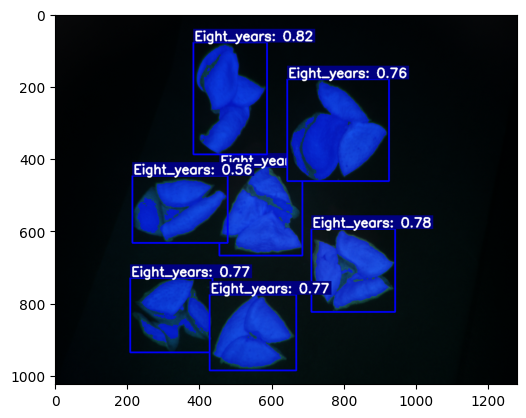

In [191]:
plt.imshow(res_img)

In [199]:
class_names = {
    0: "Three_years",
    1: "Five_years", 
    2: "Eight_years",

}

class ChenpiDetector:
    def __init__(self, model_file):
        """
        @param model_file: 算法模型文件,joblib格式
        """
        if not os.path.exists(model_file):
            raise Exception("file not exist!")
        self.model = YOLOv12(model_file , 0.1 , 0.1)

    def read_roi(self, norm_cube):
        return None

    def detect(self, norm_images, rois):
        """塑料类别预测
        传入多光谱塑料样本的ROI区域,推测其类别
        @param roi_images:提取过后的ROI多光谱图像
        @return:类别信息,如{"result": "pc"}
        """

        self.rgb_img = cv2.merge([norm_images[:,:,0], norm_images[:,:,int(norm_images.shape[2]/2)], norm_images[:,:,-1]])
        self.boxes, self.scores, self.class_ids = self.model.main(self.rgb_img)
        result=None
        return result
    

    def draw_img(self, norm_obj_cube, rois, result):
        res_img , legend= self.model.draw_img(self.rgb_img, self.boxes, self.scores, self.class_ids, class_names = class_names)

        return res_img, legend

In [200]:
import glob
png_list = glob.glob(rf'I:\experiment_data\国创报告\陈皮国创演示\data\320250926_025032\png\*.png')

all_img = []
for png in png_list:
    img = cv2.imdecode(np.fromfile(png,dtype=np.uint8),-1)
    all_img.append(img)

all_img = np.array(all_img)
all_img = all_img.transpose(1,2,0)

In [201]:
detector = ChenpiDetector(r'I:\experiment_data\国创报告\陈皮国创演示\last.onnx')
rois = detector.read_roi(all_img)
result = detector.detect(all_img, rois)
mask, legend = detector.draw_img(all_img, rois, result)

d:\Anaconda\envs\yolov8\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


In [204]:
import onnxruntime 
print(onnxruntime.__version__)

1.16.3


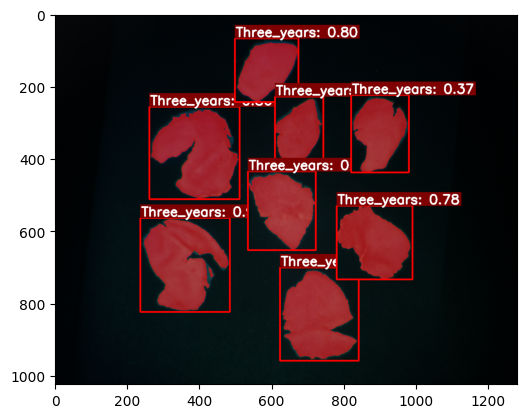

In [202]:
plt.imshow(mask)

In [207]:
import spectral
a = spectral.open_image(rf'I:\experiment_data\国创报告\陈皮国创演示\data\320250926_025122\ENVI_320250926_025122.hdr').load()

In [208]:
a.max()

845.0